In [3]:
from sys import stdout
import numpy as np
from matplotlib import pyplot as plt
import mdtraj
import openmm as mm
from openmm.app import *
from openmm import unit
from openmm.app.simulation import Simulation
from AIGLE.utilities import *

## System Parameters
nmain = 20  # number of backbone atoms
nside = 5   # number of dangling atom each backbone atom is connected
mass_M = np.ones(nmain) * 12.0 * unit.amu  ## mass of backbone atoms
np.random.seed(1234)
mass_S = np.random.uniform(1,20, (nmain,nside)) * unit.amu   ## mass of dangling atoms
k_main = 1000.0 * unit.kilojoule_per_mole / unit.nanometer**2   # elastic constant for springs connecting backbone atoms
k_side = 1000.0 * unit.kilojoule_per_mole / unit.nanometer**2   # elastic constant for springs connecting backbone atom and dangling atoms
temp = 300 * unit.kelvin
kbT = 2.4943387854 * unit.kilojoule_per_mole

d_main = 0.3   # equilibrium length 
d_side = 0.12  # equilibrium length
nm = unit.nanometer

## Create a system in OPENMM
system = mm.System()
topol = topology.Topology()
chain = topol.addChain()
init_positions = []
indices_main = []

## Add particles to the system
for ii in range(nmain):
    idx=system.addParticle(mass_M[ii])
    indices_main.append(idx)
    pos = np.array([ii , 0,0]) * d_main
    init_positions.append(pos)
    residue = topol.addResidue('R{}'.format(ii), chain)
    topol.addAtom('C{}'.format(ii), Element.getBySymbol('C'), residue)
    for jj in range(nside):
        system.addParticle(mass_S[ii,jj])
        topol.addAtom('H{}-{}'.format(ii,jj), Element.getBySymbol('H'), residue )
        
        vec_side = np.random.randn(3)   
        vec_side = vec_side / np.linalg.norm(vec_side)  * d_side
        pos_side =  pos + vec_side 
        init_positions.append(pos_side)     
init_positions = np.array(init_positions) * nm

## Add harmonic forces
custom_force  = mm.openmm.HarmonicBondForce()
n = nside+1
for ii in range(nmain-1):
    custom_force.addBond( n*ii, n*(ii+1), d_main * nm, k_main)
    topol.addBond(n*ii, n*(ii+1) )
for ii in range(nmain):
    for jj in range(nside):
        custom_force.addBond( n*ii, n*ii+jj+1, d_side * nm, k_side)
        topol.addBond(n*ii, n*ii+jj+1)  
system.addForce(custom_force )



0

## all-atom simulation

In [ ]:
## NVT parameters
temperature = 300 * unit.kelvin
dt = 2 * unit.femtoseconds
tau_t = 10 * unit.picosecond

## MD setup
integrator = mm.openmm.LangevinIntegrator(temperature, 1 / tau_t, dt)
simulation = Simulation(topol, system, integrator)
simulation.context.setPositions(init_positions)
# simulation.minimizeEnergy()

## relax 
simulation.step( 2*int(tau_t / dt) )

## run
simulation.reporters = [
    mdtraj.reporters.DCDReporter("traj_N{}.dcd".format(nmain), 1, atomSubset=indices_main ),
    # pdbreporter.PDBReporter("md_data/traj_N{}.pdb".format(nmain), 10000),
    StateDataReporter(stdout, 100000, step=True, time=True, temperature=True, elapsedTime=True),
]

simulation.step(5000000)

/home/pinchenx/data.gpfs/envs/openmm/lib/python3.10/site-packages/mdtraj/utils/validation.py:115: TypeCastPerformanceWarning: Casting xyz dtype=float64 to <class 'numpy.float32'> 
  warnings.warn("Casting %s dtype=%s to %s " % (name, val.dtype, dtype),


#"Step","Time (ps)","Temperature (K)","Elapsed Time (s)"
100000,200.00000000022686,324.7322065375749,0.0005104541778564453
200000,400.00000000118183,318.9284243553818,86.83233261108398
300000,599.9999999996356,301.96333046852874,173.67899084091187
400000,799.9999999949063,329.9665390602021,260.5808005332947
500000,999.9999999901769,301.1010139761089,347.5019369125366
600000,1199.9999999854476,318.2102917199059,434.3364963531494
700000,1399.9999999807183,312.8387377241651,521.1656339168549
800000,1599.9999999759889,299.03125377859095,608.0263171195984
900000,1799.9999999712595,308.3292891756772,694.8234972953796
1000000,1999.9999999665301,300.5685644472018,781.6323909759521
1100000,2199.9999999618008,318.6864195031414,868.4965553283691
1200000,2399.9999999570714,311.03058302828754,955.2887661457062
1300000,2599.999999952342,274.24146995600427,1042.146818637848
1400000,2799.9999999476127,315.9103885829116,1129.0284309387207
1500000,2999.9999999428833,347.4528571642634,1215.8519141674042


## Load backbone trajectory and save as numpy array

In [5]:
## load trajectories of main atoms
main_topol = mdtraj.Topology()
chain = main_topol.add_chain()
for ii in range(nmain):
    residue = main_topol.add_residue('R{}'.format(ii), chain)
    main_topol.add_atom('C{}'.format(ii), Element.getBySymbol('C'), residue) 
main_atoms = [x for x in main_topol.atoms]
for ii in range(nmain-1):
    main_topol.add_bond(main_atoms[ii], main_atoms[ii+1])

## extract the trajectory of coarse-grained variables (backbone atoms) from the all-atom trajectory
traj  = mdtraj.load("traj_N{}.dcd".format(nmain), top=main_topol)
np.save('traj_2fs.npy', traj.xyz)

## Analyze mean-squared displacement of head-tail distance

In [11]:
from AIGLE import Trajectory
traj = np.load('traj_2fs.npy')
htd = traj[:,-1] - traj[:,0]   # tail coordinate - head coordinate, shape=(nframes, 3)

dt=0.002
stride = 50
msd_dt = stride * dt
nmax = int(100/msd_dt)  ## calculate MSD for 100ps
cv_traj = Trajectory(htd[::stride], msd_dt)
cv_traj.process_kinetics(transform=False)
msd=cv_traj.compute_msd(nmax=nmax)

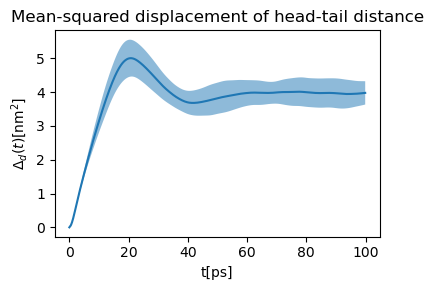

In [14]:
## plot
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(np.arange(nmax)*msd_dt, msd.sum(-1), )
ax.fill_between(np.arange(nmax)*msd_dt, msd.sum(-1)+msd.std(-1) * 3, msd.sum(-1)-msd.std(-1) * 3, alpha=0.5)

ax.set_xlabel('t[ps]')
ax.set_ylabel(r'$\Delta_d(t) [\text{nm}^2]$')
ax.set_title('Mean-squared displacement of head-tail distance')
plt.tight_layout()